In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

I am building a classifier that reads raw emails and decides whether an email is spam or ham. The goal is to read the messages and provide value to the user by removing all the emails that are spam, thus saving them time. 

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

I received a zip file on Schoology for the data. When I unpacked the data, it showed hundreds of text files where each text file represents an email. The first line of each file represents the subject while the remaining lines represent the body of the email. 


In [2]:
from pathlib import Path
import pandas as pd
import re

data_dir = Path("email_archive")

def read_email(path: Path):
    text = path.read_text(encoding="utf-8", errors="ignore")
    lines = text.splitlines()

    subject = ""
    subj_idx = None
    for i, line in enumerate(lines[:10]):
        m = re.match(r'^\s*subject\s*(.*)$', line, flags=re.I)
        if m:
            subject = m.group(1).strip()
            subj_idx = i
            break

    body_lines = lines[:subj_idx] + lines[subj_idx+1:] if subj_idx is not None else lines
    body = "\n".join(body_lines).strip()
    return subject, body

file_list = sorted(list(data_dir.rglob("*.txt")) + list(data_dir.rglob("*.TXT")))

rows = [{"path": str(p), "subject": read_email(p)[0], "body": read_email(p)[1]} for p in file_list]
df = pd.DataFrame(rows)

print("Files parsed", len(file_list))
df.head(3)


Files parsed 875


path  \
0  email_archive/.ipynb_checkpoints/3-1msg1-check...   
1  email_archive/.ipynb_checkpoints/3-392msg1-che...   
2  email_archive/.ipynb_checkpoints/spmsgc99-chec...   

                              subject  \
0          : re : 2 . 882 s - > np np   
1  : humor communication : call paper   
2           : ' t stand ! ! ! ! ! ! !   

                                                body  
0  > deat : sun , 15 dec 91 2 : 25 : 2 est > : mi...  
1  call papers humor communication seminar sca , ...  
2  dear internet user : dear internet user : soun...

# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

I explored the data by analyzing the basic features it has. This includes how many emails there are, how long the subjects and bodies are, how often links, addresses, and quotes appear. I also plan on noting bias like analyzing sentiment and while manually looking through the data, I noticed that a lot of the messages seem to be academic. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt

assert not df.empty, "No emails loaded"

df["subject_len"] = df["subject"].fillna("").str.len()
df["body_len"] = df["body"].fillna("").str.len()

def count_pat(s, pattern):
    return s.fillna("").str.count(pattern, flags=re.I)

df["num_urls"]   = count_pat(df["body"], r"http[s]?://|www\.")
df["num_emails"] = count_pat(df["body"], r"[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,}")
df["num_quotes"] = count_pat(df["body"], r"(?m)^\s*>")

print("Total emails", len(df))
print("Empty subject", (df['subject'].fillna("")=="").sum())
print("Empty body", (df['body'].fillna("")=="").sum())

display(df[["subject_len","body_len","num_urls","num_emails","num_quotes"]].describe().round(2))


Total emails 875
Empty subject 0
Empty body 0


subject_len  body_len  num_urls  num_emails  num_quotes
count       875.00    875.00     875.0       875.0      875.00
mean         28.23   2608.42       0.0         0.0        0.01
std          15.38   3271.41       0.0         0.0        0.09
min           1.00     14.00       0.0         0.0        0.00
25%          17.00    549.00       0.0         0.0        0.00
50%          26.00   1366.00       0.0         0.0        0.00
75%          37.00   3250.00       0.0         0.0        0.00
max         128.00  19322.00       0.0         0.0        1.00

From here, I made some plots to visualize my data and to see what I would need to clean:

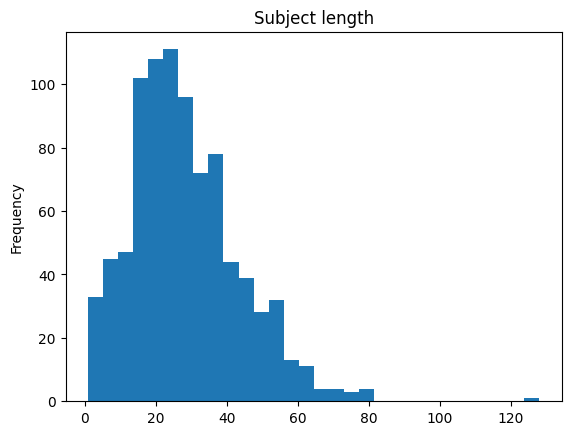

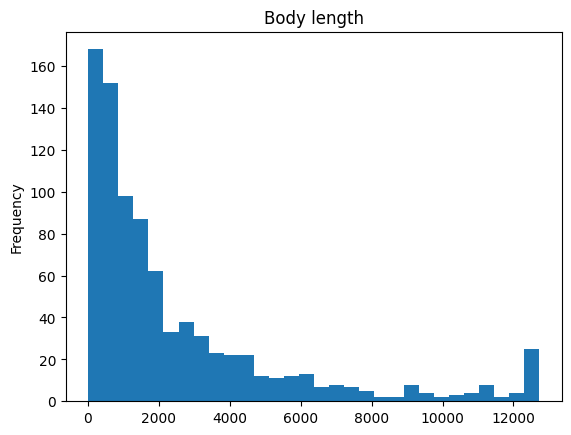

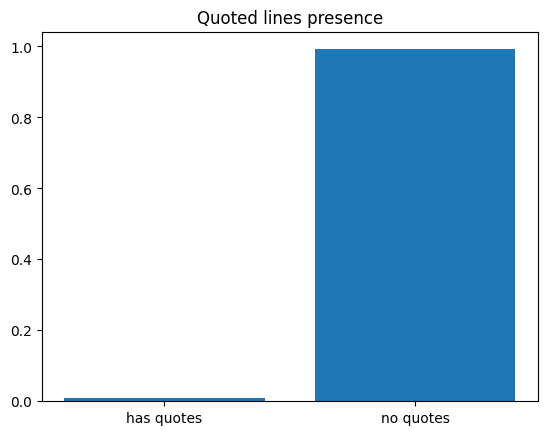

In [4]:
plt.figure(); df["subject_len"].plot(kind="hist", bins=30, title="Subject length"); plt.show()
plt.figure(); df["body_len"].clip(upper=df["body_len"].quantile(0.98)).plot(kind="hist", bins=30, title="Body length"); plt.show()
plt.figure(); plt.bar(["has quotes","no quotes"], [(df["num_quotes"]>0).mean(), 1-(df["num_quotes"]>0).mean()]); plt.title("Quoted lines presence"); plt.show()


# 4.Prepare the Data


Apply any data transformations and explain what and why

Since the quoted text appeared to be rare, I will focus on fixint spaced punctuation, normalizing case and whitespace, and mapping links and emails to tokens. Additionally I will remove header noies like the From or Date lines that leaked into the body. I kept the url and email flags and added counts of digits and currentcy symbols. Finally, I added exclamation count, word count, and a bunch of spam words as filters. The cleaned emails are saved to a separate csv file. 

In [5]:
import re

URL_TOKEN = "URLTOKEN"
EMAIL_TOKEN = "EMAILTOKEN"

HEADER_RE = re.compile(
    r"(?im)^(from|to|cc|bcc|date|organization|path|newsgroups|lines|message-id)\s*[:\-].*$"
)

def drop_header_like_lines(t):
    return "\n".join(
        line for line in t.splitlines()
        if not HEADER_RE.match(line.strip())
    )

def protect_urls_and_emails(t):
    t = re.sub(r"http[s]?://\S+|www\.\S+", URL_TOKEN, t, flags=re.I)
    t = re.sub(r"[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,}", EMAIL_TOKEN, t, flags=re.I)
    return t

def fix_spaced_punct(t):
    t = re.sub(r"\s*([.,!?()\-+*/<>])\s*", r"\1", t)
    t = re.sub(r"\s+", " ", t)
    return t.strip()

def basic_clean(t):
    if not isinstance(t, str):
        return ""
    t = t.lower()
    t = drop_header_like_lines(t)
    t = protect_urls_and_emails(t)
    t = fix_spaced_punct(t)
    return t

clean_df = df.copy()
clean_df["subject_clean"] = clean_df["subject"].apply(basic_clean)
clean_df["body_clean"]    = clean_df["body"].apply(basic_clean)

# Features that fit this set
clean_df["subject_len_chars"] = clean_df["subject_clean"].str.len()
clean_df["body_len_chars"]    = clean_df["body_clean"].str.len()
clean_df["word_count"]        = clean_df["body_clean"].str.split().str.len().fillna(0)

# Keep url and email signals from Step 3
clean_df["has_url"]   = (df["num_urls"]>0).astype(int)
clean_df["has_email"] = (df["num_emails"]>0).astype(int)

# Extra lightweight signals
clean_df["num_exclaim"]  = df["body"].str.count("!").fillna(0)
clean_df["num_digits"]   = df["body"].str.count(r"\d").fillna(0)
clean_df["num_currency"] = df["body"].str.count(r"[$€£]").fillna(0)

# Uppercase ratio on raw body to catch shouty messages
def upper_ratio(s):
    s = s if isinstance(s, str) else ""
    letters = re.findall(r"[A-Za-z]", s)
    if not letters:
        return 0.0
    upp = sum(1 for ch in letters if ch.isupper())
    return upp / len(letters)

clean_df["upper_ratio"] = df["body"].apply(upper_ratio)

# Tiny spam lexicon score
spam_words = [
    "free","win","winner","credit","offer","urgent","click","buy","deal",
    "guarantee","call","limited","money","prize","subscribe"
]
pat = re.compile(r"\b(" + "|".join(spam_words) + r")\b", flags=re.I)

def spam_score(text):
    if not isinstance(text, str):
        return 0
    return len(pat.findall(text))

clean_df["spam_lex_score"] = (clean_df["subject_clean"] + " " + clean_df["body_clean"]).apply(spam_score)

cols = [
    "path","subject_clean","body_clean",
    "subject_len_chars","body_len_chars","word_count",
    "has_url","has_email","num_exclaim","num_digits","num_currency","upper_ratio","spam_lex_score"
]
display(clean_df[cols].head(3))

clean_df[cols].to_csv("emails_clean_small.csv", index=False)

path  \
0  email_archive/.ipynb_checkpoints/3-1msg1-check...   
1  email_archive/.ipynb_checkpoints/3-392msg1-che...   
2  email_archive/.ipynb_checkpoints/spmsgc99-chec...   

                        subject_clean  \
0               : re : 2.882 s->np np   
1  : humor communication : call paper   
2                  : ' t stand!!!!!!!   

                                          body_clean  subject_len_chars  \
0  >deat : sun,15 dec 91 2 : 25 : 2 est>: michael...                 21   
1  call papers humor communication seminar sca,19...                 34   
2  dear internet user : dear internet user : soun...                 18   

   body_len_chars  word_count  has_url  has_email  num_exclaim  num_digits  \
0             627          77        0          0            0          13   
1            3334         315        0          0            0         143   
2           10627        2089        0          0           45         367   

   num_currency  upper_ratio  spam_lex_score  
0             0          0.0               0  
1             0          0.0               3  
2            12          0.0              26

# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 
